## 1. Cloning Grounding Dino 📥
GD is currently published online in a *repo*, a platform publicly hosting code. We will clone it into the machine so we can use it freely. 

In this cell, we import the `os` library, which allows us to interact with the operating system. We then use `os.getcwd()` to get the current working directory, which will be stored in a variable named `projectdir`. Finally, we print the value of `projectdir` to verify the current directory.

In [1]:
import os
projectdir = os.getcwd()
projectdir

'/Users/pattphurtivilai/CV_WorkShop'

 We import the `torch` library for deep learning and the `requests` library for downloading files from the internet. We also clone the GroundingDINO repository from GitHub, which contains the code we'll be using in this workshop.

In [2]:
import torch
import requests

# Clone the repository
os.system("git clone https://github.com/IDEA-Research/GroundingDINO.git")

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


32768

##  2. Download Weight File 🏋️‍♂️
When a machine learning model is trained, the information it has learnt is saved as a **model**. 
Here, we will be downloading an already-existing weight file so that our model knows how to identify objects from the get go!

In this cell, we create a directory called `weights` to store the weight file for our model. We then change our working directory to `weights` and download the weight file from a specified URL using the `requests` library. If the download is successful, we save the file in the `weights` directory and print a confirmation message. Otherwise, we print an error message.


In [3]:
# Create a directory for weights
weights_dir = os.path.join(projectdir,"weights")
os.makedirs(weights_dir, exist_ok=True)
if not os.path.exists("weights/groundingdino_swint_ogc.pth"):
    # Change directory to the weights directory
    os.chdir(weights_dir)
    # Download the weight file
    weight_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
    weight_filename = os.path.basename(weight_url)
    weight_filepath = os.path.join(weights_dir, weight_filename)

    response = requests.get(weight_url)
    if response.status_code == 200:
        with open(weight_filepath, 'wb') as f:
            f.write(response.content)
        print("Weight file downloaded successfully.")
    else:
        print(f"Failed to download weight file. Status code: {response.status_code}")

## 3. Load Model 🤖
In this section, we import the necessary modules and define paths for the GroundingDINO model configuration and weights. We then use the `load_model` function from the `groundingdino.util.inference` module to load the model with the specified configuration and weights. This prepares our model to be used right away!

In [4]:
import os
os.chdir(projectdir)
%cd GroundingDINO

/Users/pattphurtivilai/CV_WorkShop/GroundingDINO


/opt/miniconda3/envs/detectionworkshop/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
from groundingdino.util.inference import load_model

# Define paths
groundingdino_dir = os.path.join(projectdir, "GroundingDINO")
model_config_path = os.path.join(groundingdino_dir, "groundingdino/config/GroundingDINO_SwinT_OGC.py")
weights_path = os.path.join(projectdir, "weights/groundingdino_swint_ogc.pth")

# Load model
model = load_model(model_config_path, weights_path)



final text_encoder_type: bert-base-uncased


## 4. Play with GroundingDINO🦖

In this cell, we perform object detection using the loaded GroundingDINO model. We define the image name, path, and text prompt for the detection, along with thresholds for boxes and text. We load the image using the `load_image` function and then use the `predict` function to perform object detection based on the specified text prompt. The detected objects are then annotated on the image using the `annotate` function. Finally, we display the annotated image using the `plot_image` function from the `supervision` module. This demonstrates the ability of our model to detect and highlight objects in an image based on textual descriptions.

torch.Size([3, 800, 1259])


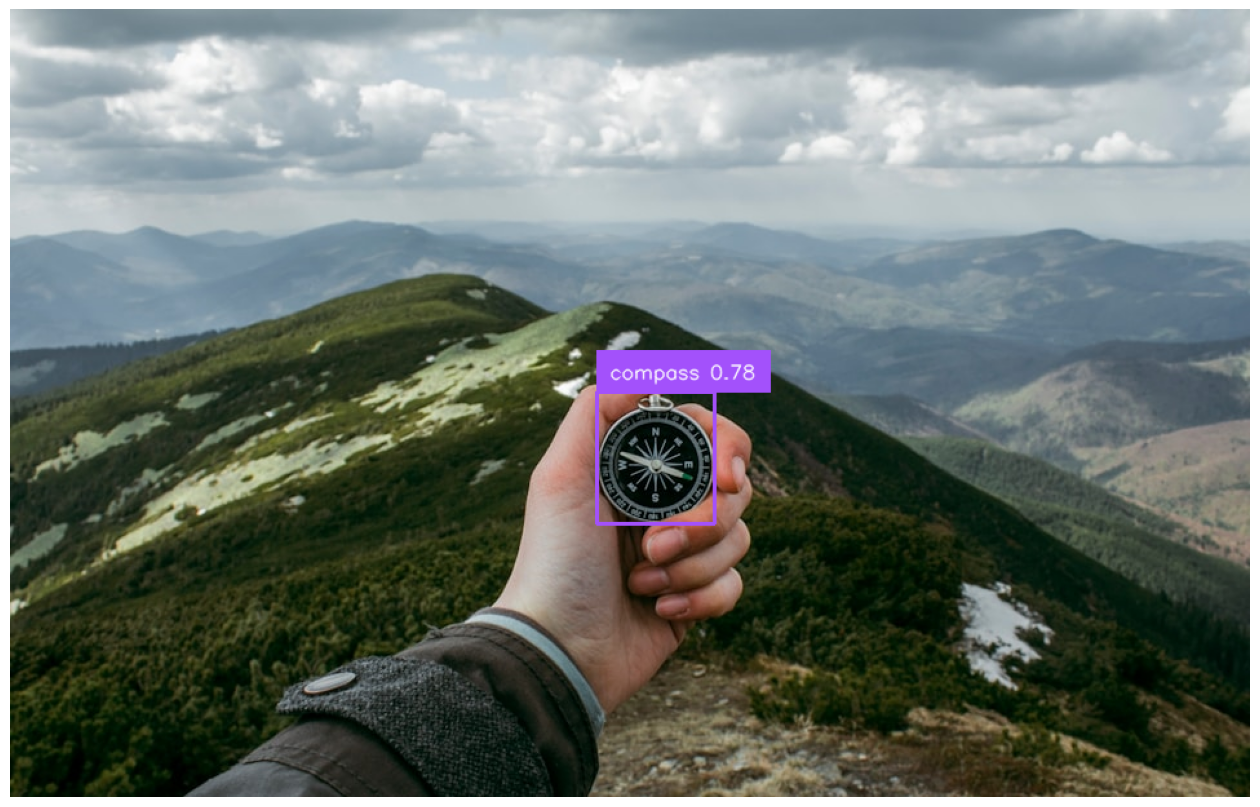

In [6]:
import supervision as sv
from groundingdino.util.inference import load_image, predict, annotate

# Define constants and paths
IMAGE_NAME = "compass.jpg"
IMAGE_PATH = os.path.join(projectdir, "datasets_GD", IMAGE_NAME)
TEXT_PROMPT = "compass"
BOX_THRESHOLD = 0.70
TEXT_THRESHOLD = 0.25
DEVICE = "cpu"  # Specify "cpu" as the device

# Load image
image_source, image = load_image(IMAGE_PATH)
print(image.shape)

# Perform object detection
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE  # Pass "cpu" as the device
)

# Annotate the image
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# Display the annotated image
sv.plot_image(annotated_frame, (16, 16))



In this cell, we apply the GroundingDINO model for object detection on a different image and text prompt. We define the image name as "hardware.jpg" and the text prompt as "spanner". 

The same process is followed as before: we load the image, perform object detection using the `predict` function with the specified text prompt and thresholds, and then annotate the detected objects on the image. Finally, we display the annotated image to visualize the results of our object detection task. This showcases the versatility of our model in detecting various objects based on textual descriptions.

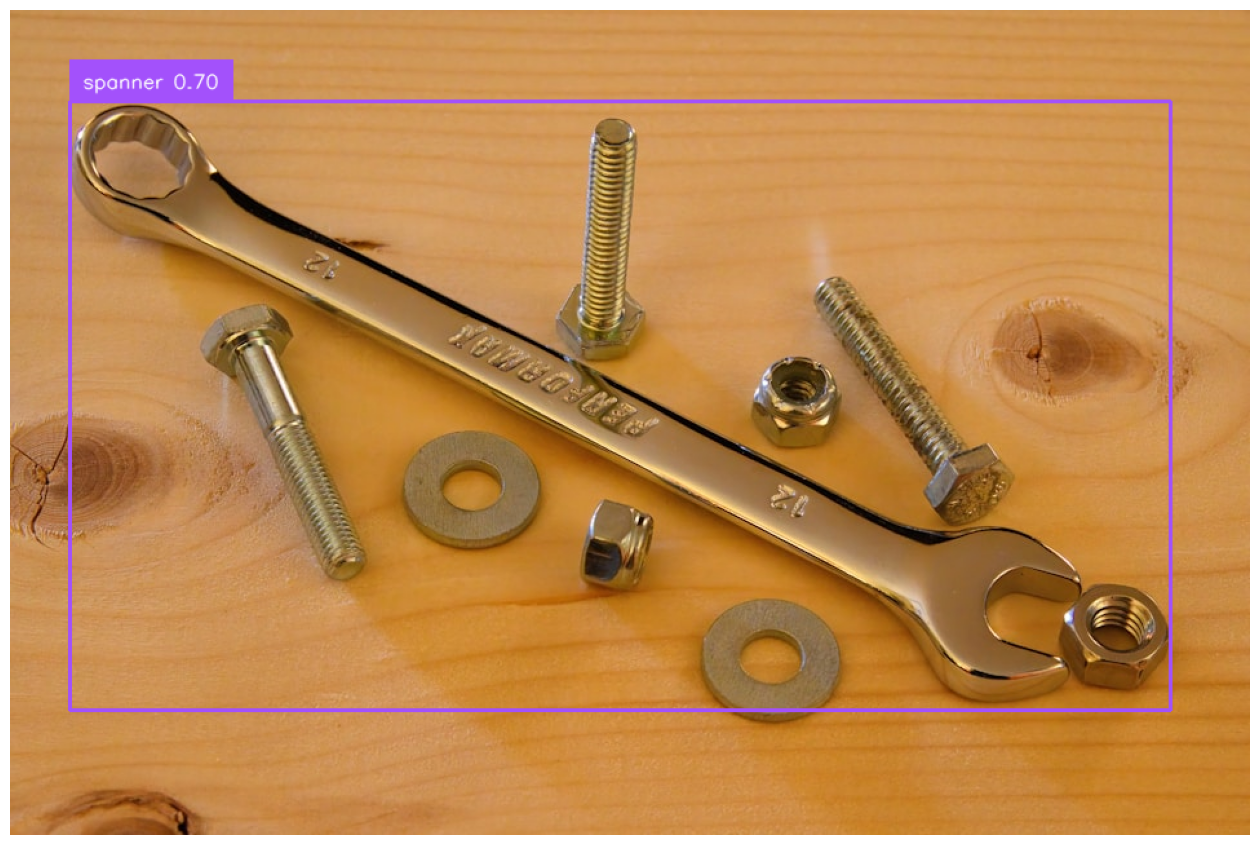

In [7]:
# Define constants and paths
IMAGE_NAME = "hardware.jpg"
IMAGE_PATH = os.path.join(projectdir, "datasets_GD", IMAGE_NAME)
TEXT_PROMPT = "spanner"
BOX_THRESHOLD = 0.70
TEXT_THRESHOLD = 0.25
DEVICE = "cpu"  # Specify "cpu" as the device

# Load image
image_source, image = load_image(IMAGE_PATH)

# Perform object detection
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE  # Pass "cpu" as the device
)

# Annotate the image
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# Display the annotated image
sv.plot_image(annotated_frame, (16, 16))

## YEAHHHHH DINO can detect spanner!!!! 🎉🎉🎉

___________________________________________________________________

## Now, time to use your own images! 😋